# Модель машиннго обучения - StackingRegressor()!!!

In [1]:
# загружаем библиотеки
import pandas as pd # работа с данными / python data analysis library
import numpy as np # библиотека для научных вычислений в python / the fundamental package for scientific computing with python
import seaborn as sns # визуализация данных / python data visualization library
import matplotlib.pyplot as plt # визуализация данных / python data visualization library

from sklearn.linear_model import LinearRegression # алгоритм линейной регрессии
from sklearn.linear_model import RidgeCV # алгоритм регуляризации
from sklearn.tree import DecisionTreeRegressor # регрессор дерева решений
from sklearn.ensemble import RandomForestRegressor # алгоритм случайный лес для задач регрессии
from sklearn.ensemble import StackingRegressor # алгоритм стекинга

from sklearn.metrics import mean_absolute_error # метрика средняя абсолютная ошибка / mean absolute error
from sklearn.metrics import mean_squared_error # метрика средняя квадратичная ошибка / mean squared error
from sklearn.metrics import mean_absolute_percentage_error # метрика средняя абсолютная процентная ошибка / mean absolute percentage error

from sklearn.model_selection import train_test_split # разделение выборки на обучающую и тестовую / train_test_split
from sklearn.feature_selection import SelectKBest, f_regression # алгоритм для выбора признаков с наивысшими оценками в модели машинного обучения на основе статистических тестов / f-regression одномерный тест линейной регрессии  
from sklearn.preprocessing import MinMaxScaler # алгоритм стандартизации данных / MinMaxScaler

from joblib import dump, load # сохранение и загрузка модели 
from colorama import Fore, Back, Style # цветовая палитра

# отключаем предупреждения
import warnings 
warnings.filterwarnings("ignore")

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING) # отключаем вывод промежуточных итогов вычислений

In [2]:
# фиксируем RANDOM_SEED, для воспроизводимости кода.
RANDOM_SEED = 369
# в данную переменную буду сохранять результаты моделей [RSME, MAE, MAPE и название алгоритма]
model_results = []

In [3]:
# описываем функцию для вывода результатов score для train, valid и test
def results_model(model, model_name):
    """Функция для вывода результатов score для train, valid и test,  
    а также для сохранения этих значений для последующего использования
    Args:
      model (model): Ссылка на обучепнную модель
      model_name (string): Название примененной модели
    """
  
    y_train_pred = model.predict(X_train)
    RMSE_train = np.sqrt(mean_squared_error(y_train, y_train_pred)).round(3)
    MAE_train = mean_absolute_error(y_train, y_train_pred).round(3)
    MAPE_train = (mean_absolute_percentage_error(y_train, y_train_pred)*100).round(3)
  
    print(f"Тренировочная выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_train:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_train:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_train:.2f}{Fore.RESET}%")
  
    y_valid_pred = model.predict(X_valid)
    RMSE_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred)).round(3)
    MAE_valid = mean_absolute_error(y_valid, y_valid_pred).round(3)
    MAPE_valid = (mean_absolute_percentage_error(y_valid, y_valid_pred)*100).round(3)
  
    print(f"Валидная выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_valid:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_valid:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_valid:.2f}{Fore.RESET}%")
  
    y_test_pred = model.predict(X_test)
    RMSE_test = np.sqrt(mean_squared_error(y_test, y_test_pred)).round(3)
    MAE_test = mean_absolute_error(y_test, y_test_pred).round(3)
    MAPE_test = (mean_absolute_percentage_error(y_test, y_test_pred)*100).round(3)
  
    print(f"Тестовая выборка:")
    print(f"    {Fore.LIGHTBLUE_EX}RMSE: {Fore.LIGHTGREEN_EX}{RMSE_test:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAE: {Fore.LIGHTGREEN_EX}{MAE_test:.3f}{Fore.RESET}")
    print(f"    {Fore.LIGHTBLUE_EX}MAPE: {Fore.LIGHTGREEN_EX}{MAPE_test:.2f}{Fore.RESET}%") 
  
    model_results.append({"RMSE_train": RMSE_train, "MAE_train": MAE_train, "MAPE_train": MAPE_train,
                        "RMSE_valid": RMSE_valid, "MAE_valid": MAE_valid, "MAPE_valid": MAPE_valid,
                        "RMSE_test": RMSE_test, "MAE_test": MAE_test, "MAPE_test": MAPE_test, 
                        'ML_model': model_name})

In [4]:
%%time
# загружаем данные
data_sr = pd.read_csv("data/data_final.csv", sep=",")

# создаем матрицу наблюдений и вектор правильных ответов
X = data_sr.drop(columns="target", axis=1)
y = data_sr["target"]

# производим разделение выборки на тренировочную и тестовую
X_train, X_validtest, y_train, y_validtest = train_test_split(X, y, train_size=0.8, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_validtest, y_validtest, test_size=0.5, random_state=RANDOM_SEED)

feature_names = X_train.columns.tolist()

# производим нормализацию обучающей и тестовой выборки с помощью MinMaxScaller
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train)
X_train = min_max_scaler.transform(X_train)
X_valid = min_max_scaler.transform(X_valid)
X_test = min_max_scaler.transform(X_test)

# загружаем модель
model_etr = load("model/model_ExtraTreesRegressor.joblib")
model_dtr = load("model/model_DecisionTreeRegressorHyperopt.joblib")
model_xgb = load("model/model_XGBoostOptuna.joblib")

# cоздаем список кортежей вида: (наименование модели, модель)
estimators = [
    ("etr", model_etr),
    ("dtr", model_dtr),
    ("xgb", model_xgb)
]

# cоздаем объект класса стекинг
model_sr = StackingRegressor(
    estimators=estimators, # базовые модели в стекинге
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1,
    verbose=1
    )
# oбучаем модель
model_sr.fit(X_train, y_train)

# делаем предсказания на тренировочной, валидной и тестовой выборках и выводим результат
results_model(model_sr, "StackingRegressor_1")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   47.4s finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 28.6min finished
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 153.8min finished


Тренировочная выборка:
    RMSE: 0.088
    MAE: 0.042
    MAPE: 0.33%
Валидная выборка:
    RMSE: 0.323
    MAE: 0.191
    MAPE: 1.51%
Тестовая выборка:
    RMSE: 0.325
    MAE: 0.192
    MAPE: 1.52%


In [5]:
# получаем мета-признаки из тренировочных данных
meta_data = model_sr.transform(X_train)
# создаем DataFrame
meta_df = pd.DataFrame(
    meta_data, #содержимое таблицы
    columns=["meta_feature1", "meta_feature2", "meta_feature3"] #название столбцов
)
meta_df.head()

,meta_feature1,meta_feature2,meta_feature3
0,11.694422,11.424620,11.782942
1,12.832188,12.596012,12.833825
2,11.349241,11.333139,11.370163
3,13.709039,13.745444,13.665671
4,12.873648,13.042060,12.851033


In [6]:
# создаем dataframe с результатами
resultsScoreData = pd.DataFrame(model_results).set_index('ML_model').sort_values(by='MAPE_test', ascending=True)
# выводим сводную информацию 
display(resultsScoreData.sort_values(by="MAPE_test", ascending=True).round(2))

,RMSE_train,MAE_train,MAPE_train,RMSE_valid,MAE_valid,MAPE_valid,RMSE_test,MAE_test,MAPE_test
ML_model,,,,,,,,,
StackingRegressor_1,0.09,0.04,0.33,0.32,0.19,1.51,0.32,0.19,1.52


In [7]:
# cохраняем модель в файл
dump(model_sr, "model/model_StackingRegressor_1.joblib")

['model/model_StackingRegressor_1.joblib']

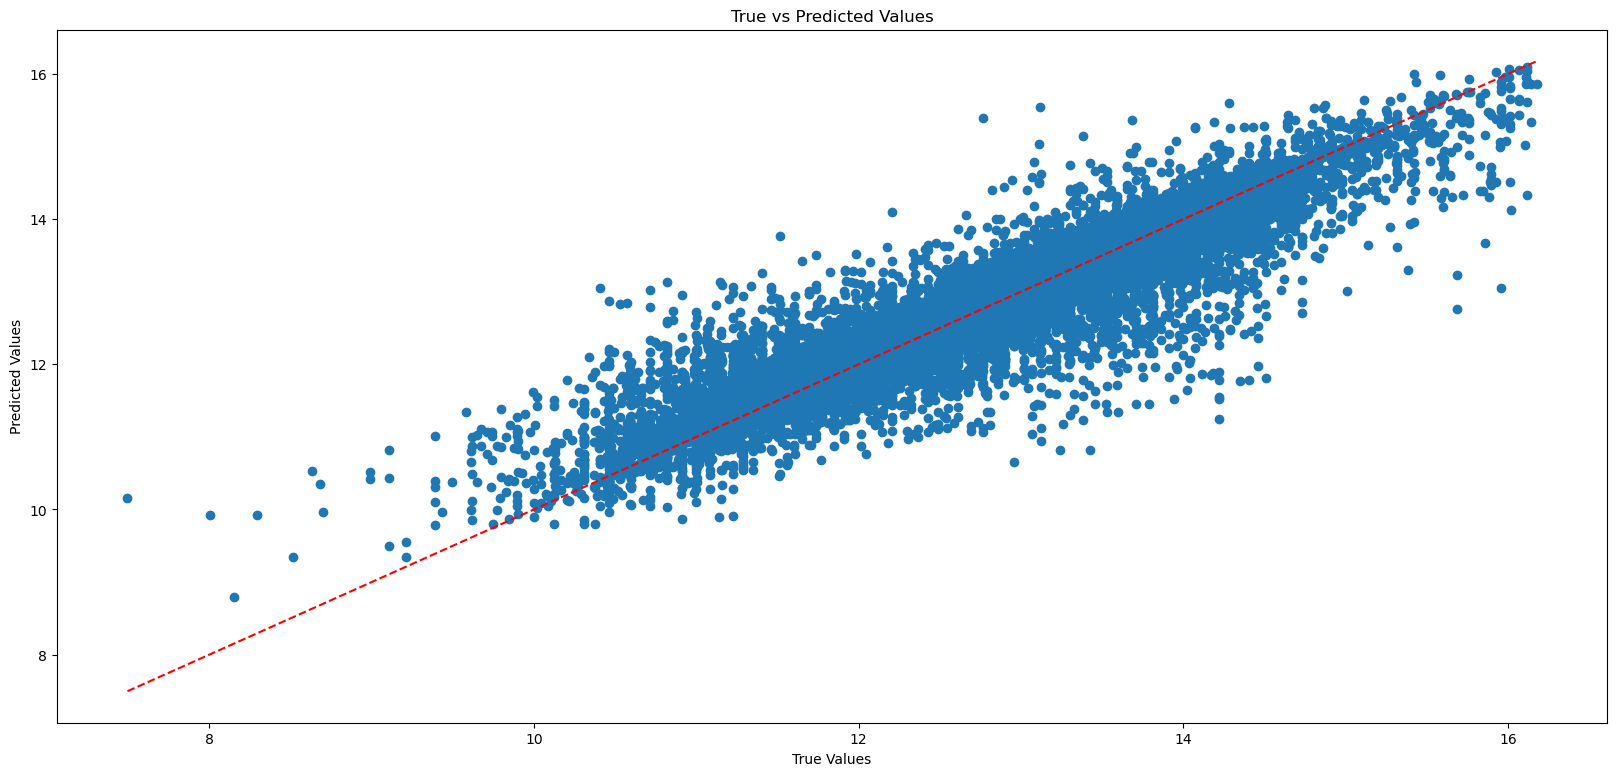

In [8]:
# график предсказанных значений против истинных значений
y_pred = model_sr.predict(X_test)
plt.figure(figsize=(20, 9))
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.show()

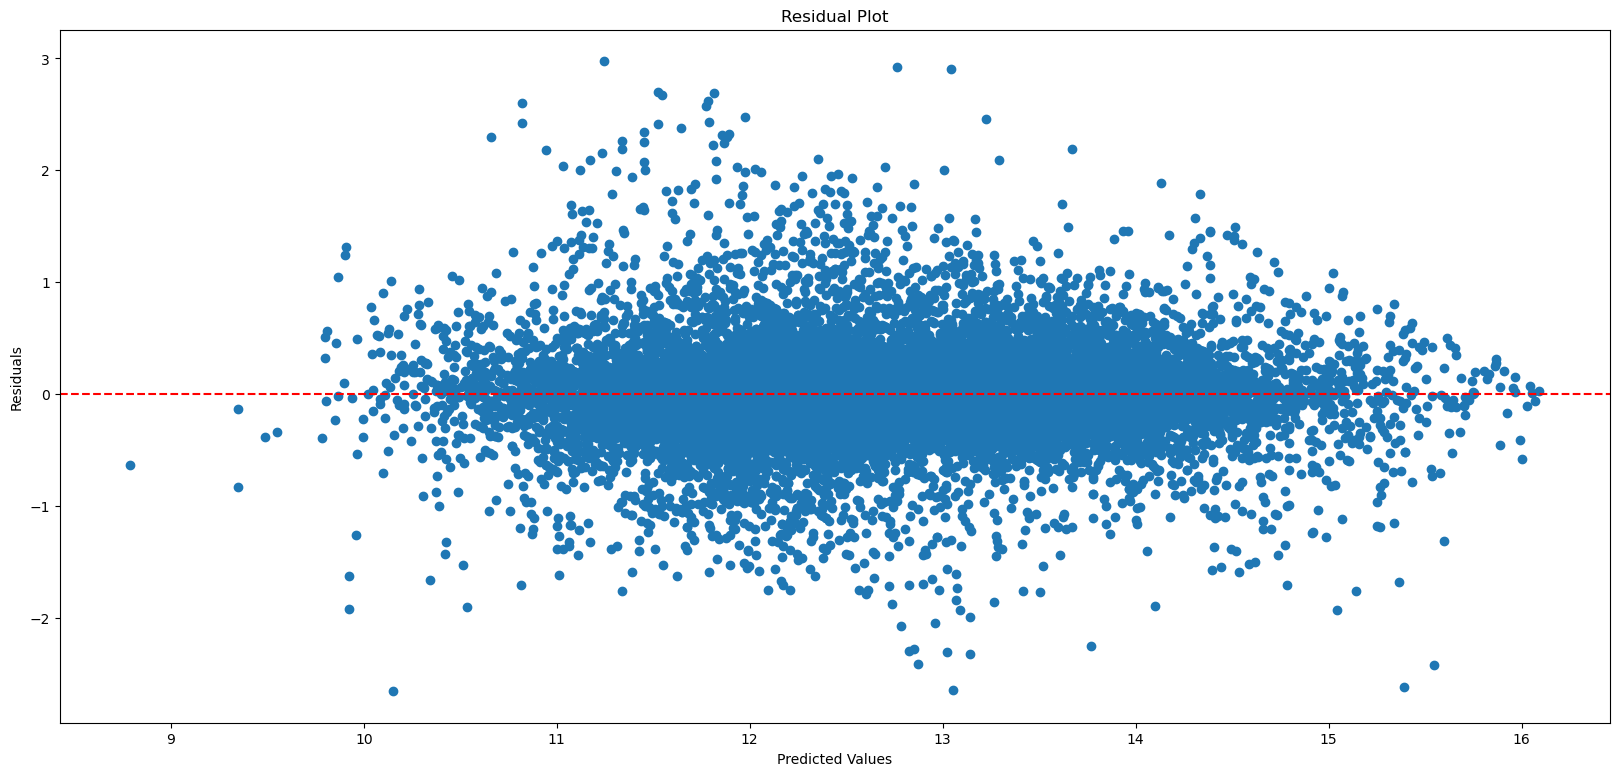

In [9]:
# график остатков на тестовой выборке
residuals = y_test - y_pred
plt.figure(figsize=(20, 9))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()